In [114]:
# defining a Value class
class Value:
    def __init__(self, data,label="",children=(),opp=""):
        '''keeping track of what is this node is made of ie- the nodes that combine to make this and which operation is used, by default grad is zero to keep track of constants also'''
        self.data = data
        self._prev = set(children)
        self.label = label
        self.opp = opp
        self.grad = 0
        self.backtrack = lambda : None

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other):
        '''applying chain rule of derivatives thus the derivative is derivative of itself*derivative of parent'''
        other = other if isinstance(other, Value) else Value(other,label=f"ct{other}")
        out = Value(self.data + other.data,children=(self,other),opp="+")

        def _backtrack():
            self.grad += out.grad
            other.grad += out.grad

        out.backtrack = _backtrack

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other,label=f"ct{other}")
        out = Value(self.data * other.data,children=(self,other),opp="*")

        def _backtrack():
            other.grad += self.data*out.grad
            self.grad += other.data*out.grad

        out.backtrack = _backtrack
        return out

    def __pow__(self, other):

        other = other if isinstance(other, Value) else Value(other,label=f"ct{other}")
        out = Value(self.data ** other.data,children=(self,other),opp="**")

        def _backtrack():
            self.grad += other.data*(self.data**(other.data-1))*out.grad

        out.backtrack = _backtrack

        return out


# atomic inputs
a = Value(2,  label="A")
b = Value(-3, label="B")
c = Value(4,  label="C")
d = Value(5,  label="D")
e = Value(-2, label="E")
f = Value(3,  label="F")
g = Value(7,  label="G")
h = Value(-6, label="H")

# layer 1
i  = a * b;     i.label  = "I"
j  = c + d;     j.label  = "J"
k  = e * f;     k.label  = "K"
l  = g + h;     l.label  = "L"

# layer 2
m  = i + j;     m.label  = "M"
n  = j * k;     n.label  = "N"
o  = k + l;     o.label  = "O"
p  = l * a;     p.label  = "P"

# layer 3
q  = m * n;     q.label  = "Q"
r  = n + o;     r.label  = "R"
s  = o * p;     s.label  = "S"

# layer 4
t  = q + r;     t.label  = "T"
u  = r * s;     u.label  = "U"
v  = s + m;     v.label  = "V"

# layer 5
w  = t * u;     w.label  = "W"
x  = u + v;     x.label  = "X"

# layer 6
y  = w + x;     y.label  = "Y"
z  = y * d;     z.label  = "Z"

# layer 7
aa = z + g;     aa.label = "AA"
ab = aa * b;    ab.label = "AB"

# final output
ac = ab + c;    ac.label = "AC"



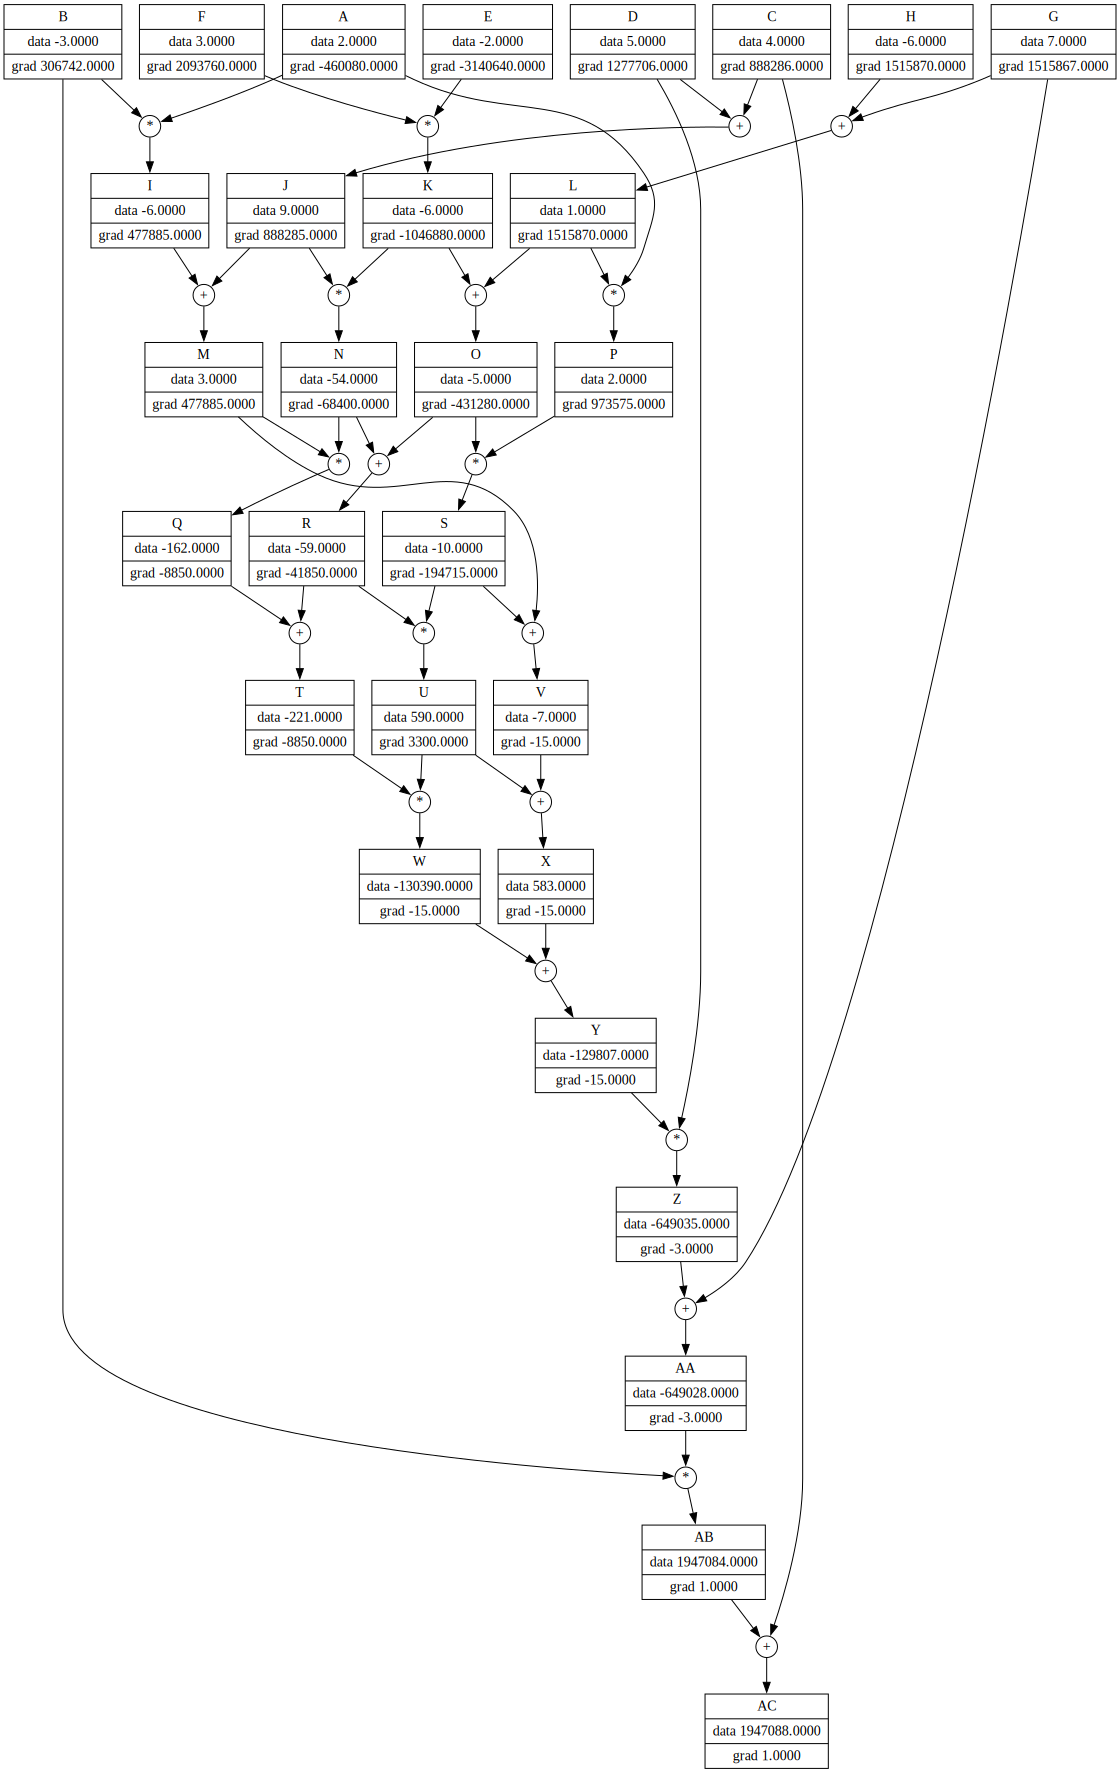

In [117]:
from graphviz import Digraph

def draw_plot(root):

    dot = Digraph(
        graph_attr={
            "rankdir": "TB",
            "splines": "spline",
            "concentrate": "true"
        }
    )

    visited_nodes = set()
    visited_edges = set()

    def add_value_node(node):
        dot.node(
            node.label,
            label=f"{{ {node.label} | data {node.data:.4f} | grad {node.grad:.4f} }}",
            shape="record"
        )

    def add_op_node(node):
        dot.node(
            node.label + node.opp,
            label=node.opp,
            shape="circle",
            width="0.3",
            height="0.3",
            fixedsize="true"
        )

    def build(node):
        if node in visited_nodes:
            return
        visited_nodes.add(node)

        add_value_node(node)

        if node.opp:
            add_op_node(node)
            edge = (node.label + node.opp, node.label)
            if edge not in visited_edges:
                dot.edge(*edge)
                visited_edges.add(edge)

        for child in node._prev:
            build(child)
            if node.opp:
                edge = (child.label, node.label + node.opp)
                if edge not in visited_edges:
                    dot.edge(*edge)
                    visited_edges.add(edge)

    build(root)
    return dot
dot = draw_plot(ac)
dot

In [116]:
def topo_sort_backtrack(target_node):
    topo = []
    visited = []
    ac.grad = 1
    #topological sort
    def topo_sort(node:Value):
        if node not in visited:
            visited.append(node)
        for child in node._prev:
            if child not in visited:
                topo_sort(child)
        topo.append(node)
    topo_sort(target_node)

    for node in reversed(topo):
        print(node.label)
        node.backtrack()

topo_sort_backtrack(ac)

AC
AB
AA
Z
Y
W
T
Q
X
V
M
I
B
U
S
P
A
R
N
J
C
O
K
E
F
L
G
H
D
